In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import datetime

In [2]:
#FETCHING DAILY DATA 
current_date = datetime.date.today()

url = f'https://api.upstox.com/v2/historical-candle/NSE_INDEX|Nifty 50/day/{current_date}/2023-10-01'
headers = {
    'Accept': 'application/json'
}

response = requests.get(url, headers=headers)

# Check the response status
if response.status_code == 200:
    # Do something with the response data (e.g., print it)
    df = response.json()
    df
else:
    # Print an error message if the request was not successful
    print(f"Error: {response.status_code} - {response.text}")

In [3]:
df = df["data"]["candles"]
# df

In [4]:
df = pd.DataFrame(df, columns=['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'OI'])

# Convert the 'Datetime' column to datetime objects
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Set the 'Datetime' column as the index and keep only the date part
df.set_index(df['Datetime'].dt.date, inplace=True)

# Drop the redundant 'Datetime' column
df.drop(columns='Datetime', inplace=True)

# Reverse the order of rows
df = df.iloc[::-1]

# Display the updated DataFrame
print(df)

                Open      High       Low     Close  Volume  OI
Datetime                                                      
2023-10-03  19622.40  19623.20  19479.65  19528.75       0   0
2023-10-04  19446.30  19457.80  19333.60  19436.10       0   0
2023-10-05  19521.85  19576.95  19487.30  19545.75       0   0
2023-10-06  19621.20  19675.75  19589.40  19653.50       0   0
2023-10-09  19539.45  19588.95  19480.50  19512.35       0   0
...              ...       ...       ...       ...     ...  ..
2024-04-16  22125.30  22213.75  22079.45  22147.90       0   0
2024-04-18  22212.35  22326.50  21961.70  21995.85       0   0
2024-04-19  21861.50  22179.55  21777.65  22147.00       0   0
2024-04-22  22336.90  22375.65  22198.15  22336.40       0   0
2024-04-23  22447.05  22447.55  22349.45  22368.00       0   0

[138 rows x 6 columns]


In [5]:
# Function to draw MACD indicator
def MACD(df):
    df['EMA12'] = df.Close.ewm(span=12).mean()
    df['EMA26'] = df.Close.ewm(span=26).mean()
    df['MACD'] = df.EMA12 - df.EMA26
    df['signal'] = df.MACD.ewm(span=9).mean()
#     print('Indicators added')

In [6]:
# Calling MACD Functioin
MACD(df)

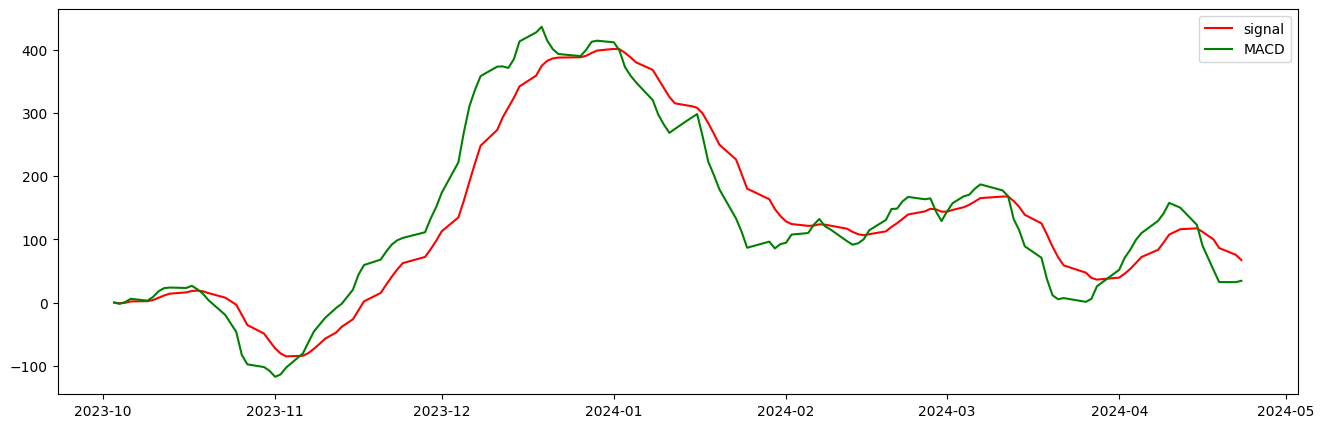

In [7]:
# Ploting MACD chart to get buy and sell signals
plt.figure(figsize=(16,5))
plt.plot(df.signal,label='signal', color = 'red')
plt.plot(df.MACD, label = 'MACD', color = 'green')
plt.legend()
plt.show()

In [8]:
Buy , Sell = [], []

for i in range (2,len(df)):
    if df.MACD.iloc[i] > df.signal.iloc[i] and df.MACD[i-1] < df.signal.iloc[i-1]:
        Buy.append(i)
    elif df.MACD.iloc[i] < df.signal.iloc[i] and df.MACD[i-1] > df.signal.iloc[i-1]:
        Sell.append(i)
         

C:\Users\comp\AppData\Local\Temp\ipykernel_8380\3294430144.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df.MACD.iloc[i] > df.signal.iloc[i] and df.MACD[i-1] < df.signal.iloc[i-1]:
C:\Users\comp\AppData\Local\Temp\ipykernel_8380\3294430144.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif df.MACD.iloc[i] < df.signal.iloc[i] and df.MACD[i-1] > df.signal.iloc[i-1]:


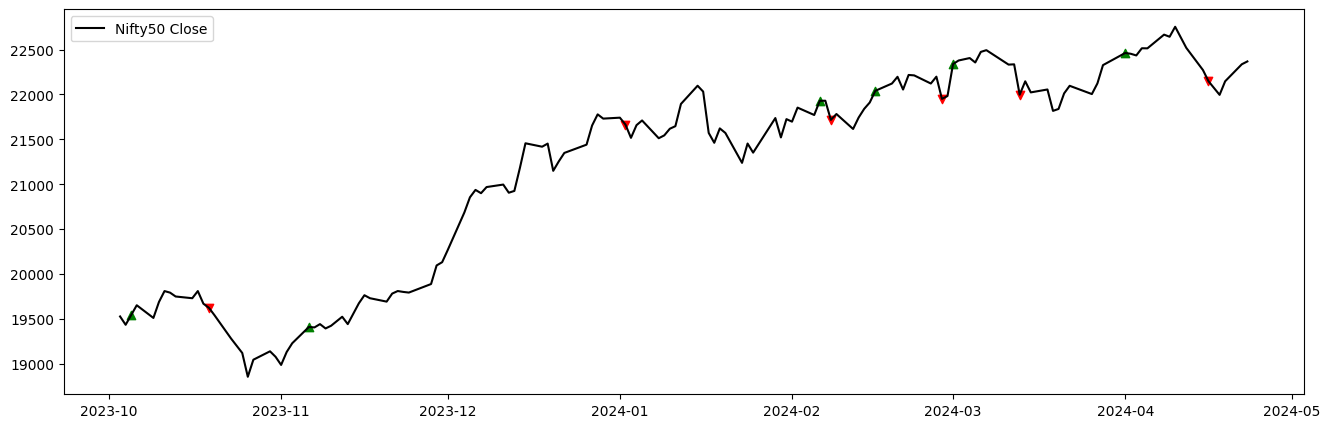

In [9]:
plt.figure(figsize=(16,5))
plt.scatter(df.iloc[Buy].index,df.iloc[Buy].Close,marker = "^", color = 'green')
plt.scatter(df.iloc[Sell].index,df.iloc[Sell].Close,marker = "v", color = 'red')
plt.plot(df.Close, label = 'Nifty50 Close', color = 'k')
plt.legend()
plt.show()

In [10]:
# BackTesting 
Realbuys = [i for i in Buy]
Realsell = [i for i in Sell]

In [11]:
Buyprices = df.Open.iloc[Realbuys]
Sellprices = df.Open.iloc[Realsell]

In [12]:
Buyprices

Datetime
2023-10-05    19521.85
2023-11-06    19345.85
2024-02-06    21825.20
2024-02-16    22020.30
2024-03-01    22048.30
2024-04-01    22455.00
Name: Open, dtype: float64

In [13]:
if Sellprices.index[0] < Buyprices.index[0]:
    Sellprices = Sellprices.drop(Sellprices.index[0])
elif Buyprices.index[-1] > Sellprices.index[-1]:
    Buyprices = Buyprices.drop(Buyprices.index[-1])
    

In [14]:
profitsrel = []

for i in range(len(Sellprices)):
    profitsrel.append(((Sellprices[i] - Buyprices[i])/Buyprices[i])*100)

C:\Users\comp\AppData\Local\Temp\ipykernel_8380\2743168462.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  profitsrel.append(((Sellprices[i] - Buyprices[i])/Buyprices[i])*100)


In [15]:
profitsrel

[0.11960956569178732,
 12.434191312348645,
 0.8451239851181236,
 0.8800970014032473,
 1.7411773243288666,
 -1.4682698730794954]

In [16]:
print(f"Total profit from 2023-10-01 is {sum(profitsrel)}%")

Total profit from 2023-10-01 is 14.551929315811172%
